In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained

from kneed import KneeLocator
from math import ceil

In [2]:
# Lecture des fichiers 
path = "data"
dfs = dict()
for dir_item in os.listdir(path):
    dir_item_path = os.path.join(path, dir_item)
    print(dir_item_path)
    if os.path.isfile(dir_item_path) and dir_item_path[:8] == "data/Exp":
        dfs[dir_item] = pd.read_csv(dir_item_path, sep=";")
dfs.keys()

data/.ipynb_checkpoints
data/ExportBales.csv
data/README.md
data/ExportBales_2.csv
data/LICENSE
data/ExportBales_1.csv
data/ExportBales_4_1.csv
data/ExportBales_4.csv


dict_keys(['ExportBales.csv', 'ExportBales_2.csv', 'ExportBales_1.csv', 'ExportBales_4_1.csv', 'ExportBales_4.csv'])

In [3]:
dfs['ExportBales.csv'].head()

,_time,bale_info_bale_length,bale_info_bale_weight,bale_info_flake_count,bale_info_moisture,bale_info_tag_#,latitude,longitude,Colonne1,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,2021-07-31T08:09:17Z,3200,211000,255,110000,1,52.115374,11.078973,1.0,NaN,NaN,NaN,NaN
1,2021-07-31T08:10:13Z,1960,361000,44,110000,2,52.115187,11.082384,1.0,NaN,NaN,NaN,NaN
2,2021-07-31T08:11:02Z,2440,445000,40,110000,3,52.115149,11.080707,1.0,NaN,NaN,NaN,NaN
3,2021-07-31T08:12:04Z,2410,430000,39,110000,4,52.115188,11.079040,1.0,NaN,NaN,NaN,NaN
4,2021-07-31T08:12:50Z,2430,454000,38,110000,5,52.115411,11.079829,1.0,NaN,NaN,NaN,NaN


In [4]:
def clustering(data, path, size_trailer=5, humidite_lim=(0,0)) :
    # Option de garder une fourchette d'humidité précise
    X = data.copy()
    if humidite_lim != (0,0):
        X = X.loc[(X["bale_info_moisture"] <= humidite_lim[0]) & (X["bale_info_moisture"] >= humidite_lim[1])]
    if X.shape[0] == 0:
        print("Il n'y a pas de ballots avec cette humidité")
        return
    # nettoyage
    X.drop(inplace=True, columns=X.columns[-5:])
    X = X.loc[:,["latitude", "longitude"]]

    # Clustering
    size_max = min(size_trailer, X.shape[0])
    print("Taille remorque :", size_max)
    n_cl = ceil(X.shape[0]/size_trailer)
    kmeans = KMeansConstrained(n_clusters=n_cl, size_max=size_max, n_init=50, max_iter=300, tol=0.0001, random_state=42)
    kmeans.fit(X)
    print("Nombre de clusters :", n_cl, "inertie :", kmeans.inertia_)
    centers = pd.DataFrame(data=kmeans.cluster_centers_, columns=X.columns)

    # Plot des données et des centres 
    plt.figure(figsize=(19,10))
    labels = kmeans.labels_
    plt.scatter(X["latitude"], X["longitude"], c=labels, cmap="Paired")
    plt.scatter(centers["latitude"], centers["longitude"], marker="*", c=list(centers.index), s=500, cmap="Paired")
    plt.axis('equal')
    plt.show()
    
    # Export des données avec leur cluster + centres 
    X["cluster"] = labels
    X.to_csv("cluster/"+path[:-4]+"_cl.csv", index=False)
    centers["cluster"] = centers.index
    centers.to_csv("cluster/"+path[:-4]+"_centers.csv", index=False)

In [92]:
def clustering(data, path, size_trailer=5) :
    # nettoyage
    X=data.copy()
    X.drop(inplace=True, columns=X.columns[-5:])
    X = X.loc[:,["latitude", "longitude"]]

    # Clustering
    size_max = min(size_trailer, X.shape[0])
    n_cl = ceil(X.shape[0]/size_trailer)
    kmeans = KMeansConstrained(n_clusters=n_cl, size_max=size_max, n_init=50, max_iter=300, tol=0.0001, random_state=42)
    kmeans.fit(X)
    print("Nombre de clusters :", n_cl, "inertie :", kmeans.inertia_)
    centers = pd.DataFrame(data=kmeans.cluster_centers_, columns=X.columns)

    '''# Plot des données et des centres 
    plt.figure(figsize=(19,10))
    labels = kmeans.labels_
    plt.scatter(X["latitude"], X["longitude"], c=labels, cmap="Paired")
    plt.scatter(centers["latitude"], centers["longitude"], marker="*", c=list(centers.index), s=500, cmap="Paired")
    plt.show()'''
    
    # Export des données avec leur cluster + centres 
    labels = kmeans.labels_
    X["cluster"] = labels
    print(X)
    X.to_csv("cluster/"+path[:-4]+"_cl.csv", index=False)
    centers["cluster"] = centers.index
    centers.to_csv("cluster/"+path[:-4]+"_centers.csv", index=False)
    
    size_camion = 2
    res_sous_cluster = pd.DataFrame()
    for i in range(n_cl) :
        cluster = X.loc[X["cluster"]==i].copy()
        n_cl_camion = ceil(cluster.shape[0]/size_camion)
        kmeans_camion = KMeansConstrained(n_clusters=n_cl_camion, size_max=size_camion, n_init=50, max_iter=300, tol=0.0001, random_state=42)
        kmeans_camion.fit(cluster)
        centers_camion = pd.DataFrame(data=kmeans_camion.cluster_centers_, columns=cluster.columns)
        
        labels_camion = kmeans_camion.labels_
        #cluster=cluster.reset_index(drop=True)
        cluster["subcluster"]= labels_camion
        #res_sous_cluster = res_sous_cluster.append(cluster, ignore_index=True)
        
        #print(res_sous_cluster)
        
        center = centers[centers["cluster"]==i]
        xcenter = center.loc[i]["latitude"]
        ycenter = center.loc[i]["longitude"]

        #print(cluster)
        centers_camion["dist"]= np.sqrt((centers_camion["latitude"]-xcenter)**2 + (centers_camion["longitude"]-ycenter)**2)
        id = 0
        
        centers_camion = centers_camion.sort_values(by="dist").reset_index()
        #print(centers_camion)
        
        dict_centers = centers_camion["index"].to_dict()
        dict_centers = {v: k for k, v in dict_centers.items()}
        
        cluster["ordre_cluster"] = cluster["subcluster"].map(dict_centers)
        
        cluster["dist_botte"] = np.sqrt((cluster["latitude"]-xcenter)**2 + (cluster["longitude"]-ycenter)**2)
        print(cluster)
        cluster = cluster.sort_values(by=['ordre_cluster','dist_botte']).reset_index(drop=True)
        print('Cluster:',cluster)

        
        
        #cluster.loc[cluster["cluster"]==centers_camion["index"]]["dist"]=centers_camion["dist"]
        #print(cluster)

        #for sb in centers_camion.sort_values(by="dist"):
        #    idx=sb.index()[0]
        #    sub_clust = cluster.loc[cluster["subcluster"]==idx].copy()
        #    subcenter = sub_clust[sub_clust["subcluster"]==idx]
        #    xsubcenter = subcenter.loc[i]["latitude"]
        #    ysubcenter = subcenter.loc[i]["longitude"]
        #    sub_clust["subdist"]= np.sqrt((sub_clust["latitude"]-xsubcenter)**2 + (sub_clust["longitude"]-ysubcenter)**2)
            #for el in sub_clust.sort_values(by=subdist):



        # Plot des données et des centres 
        plt.figure(figsize=(19,10))
        ax=plt.axes()
        labels = kmeans_camion.labels_
        #Affichage du sous-clustering
        plt.scatter(cluster["latitude"], cluster["longitude"], c=cluster["subcluster"], cmap="Paired")
        #Affichage des autres clusters
        plt.scatter(X[X["cluster"]!=i]["latitude"], X[X["cluster"]!=i]["longitude"], c="lightgrey")
        #Affichage des autres centres
        plt.scatter(centers[centers["cluster"]!=i]["latitude"], centers[centers["cluster"]!=i]["longitude"], marker="*", c="lightgrey", s=500)
        #Affichage du centre du cluster étudié
        plt.scatter(centers[centers["cluster"]==i]["latitude"], centers[centers["cluster"]==i]["longitude"], marker="*", c="black", s=500)
        
        #On ajoute l'ordre de ramassage
        cluster.index+=1
        for k, v in cluster[["latitude","longitude"]].iterrows():
            ax.annotate(k, v, xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=18, color='darkslategrey')
            
        plt.show()
        cluster.reset_index(level=0, inplace=True)
        print(cluster)
        res_sous_cluster = res_sous_cluster.append(cluster.drop(['ordre_cluster','dist_botte'],axis=1), ignore_index=True)
    
    # export fichier sous cluster
    print(res_sous_cluster)
    res_sous_cluster.to_csv("cluster/"+path[:-4]+"_ss_cl.csv", index=False)

Nombre de clusters : 3 inertie : 2.0967124559999005e-06
     latitude  longitude  cluster
0   52.116077  11.083267        0
1   52.116089  11.085686        2
2   52.116138  11.084403        1
3   52.116165  11.083136        0
4   52.116232  11.083386        0
5   52.116208  11.084310        1
6   52.116166  11.085495        2
7   52.116275  11.085149        2
8   52.116293  11.084331        1
9   52.116326  11.083135        0
10  52.116405  11.082807        0
11  52.116376  11.083880        1
12  52.116357  11.084805        2
13  52.116440  11.084763        2
14  52.116478  11.083629        1
15  52.116502  11.082610        0
16  52.116549  11.083111        0
17  52.116512  11.084755        2
     latitude  longitude  cluster  subcluster  ordre_cluster  dist_botte
0   52.116077  11.083267        0           3              1    0.000318
3   52.116165  11.083136        0           1              2    0.000173
4   52.116232  11.083386        0           1              2    0.000334
9   52

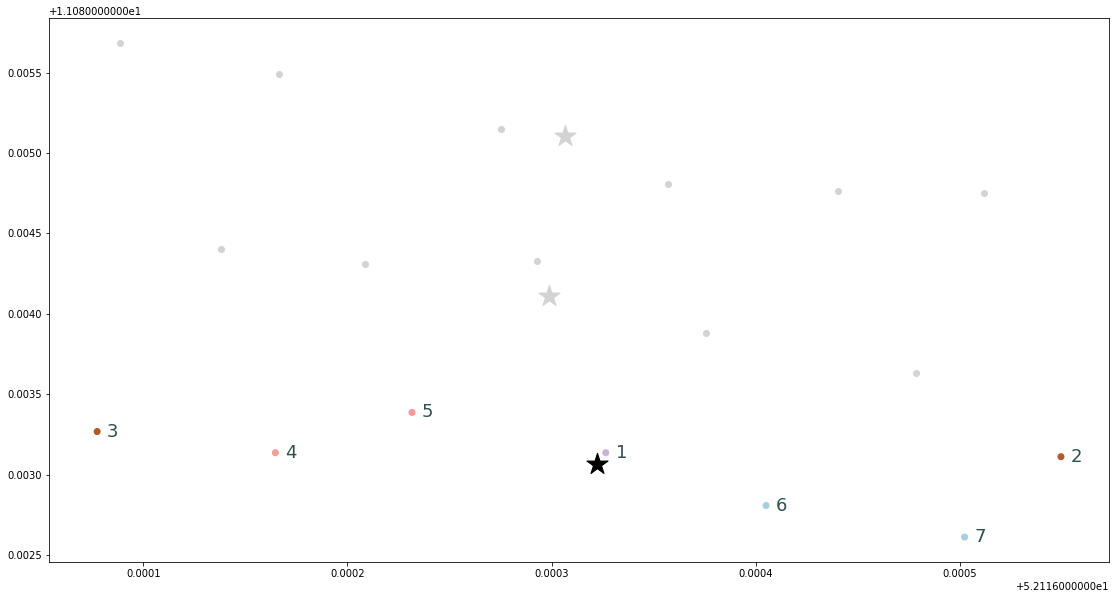

   index   latitude  longitude  cluster  subcluster  ordre_cluster  dist_botte
0      1  52.116326  11.083135        0           2              0    0.000071
1      2  52.116549  11.083111        0           3              1    0.000232
2      3  52.116077  11.083267        0           3              1    0.000318
3      4  52.116165  11.083136        0           1              2    0.000173
4      5  52.116232  11.083386        0           1              2    0.000334
5      6  52.116405  11.082807        0           0              3    0.000271
6      7  52.116502  11.082610        0           0              3    0.000488
     latitude  longitude  cluster  subcluster  ordre_cluster  dist_botte
2   52.116138  11.084403        1           2              1    0.000334
5   52.116208  11.084310        1           0              0    0.000219
8   52.116293  11.084331        1           2              1    0.000220
11  52.116376  11.083880        1           1              2    0.000243
14 

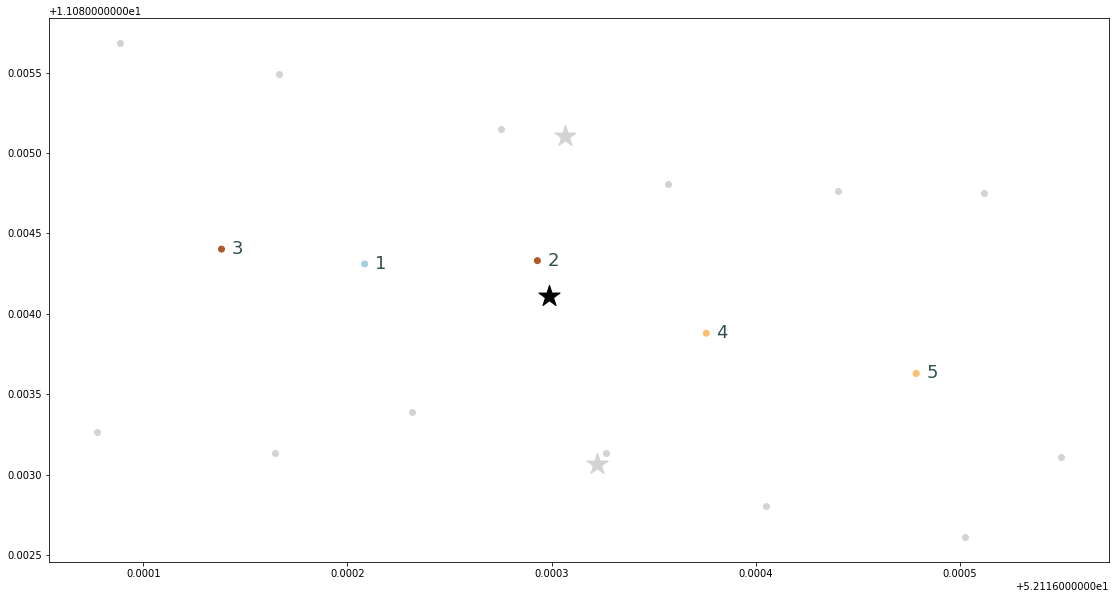

   index   latitude  longitude  cluster  subcluster  ordre_cluster  dist_botte
0      1  52.116208  11.084310        1           0              0    0.000219
1      2  52.116293  11.084331        1           2              1    0.000220
2      3  52.116138  11.084403        1           2              1    0.000334
3      4  52.116376  11.083880        1           1              2    0.000243
4      5  52.116478  11.083629        1           1              2    0.000514
     latitude  longitude  cluster  subcluster  ordre_cluster  dist_botte
1   52.116089  11.085686        2           2              2    0.000617
6   52.116166  11.085495        2           2              2    0.000411
7   52.116275  11.085149        2           0              0    0.000051
12  52.116357  11.084805        2           0              0    0.000308
13  52.116440  11.084763        2           1              1    0.000371
17  52.116512  11.084755        2           1              1    0.000409
Cluster:     la

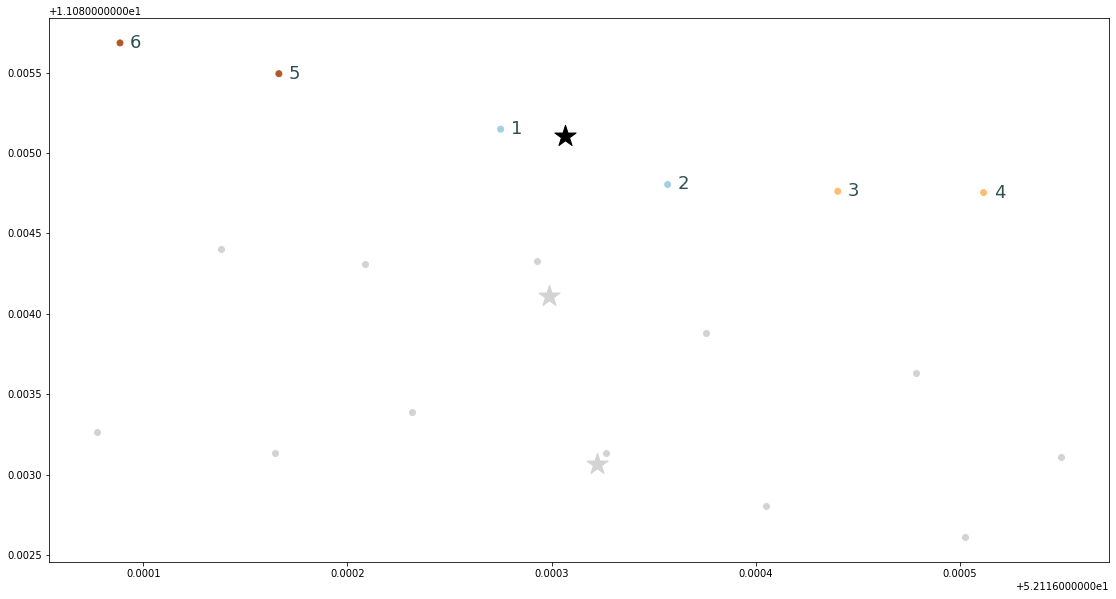

   index   latitude  longitude  cluster  subcluster  ordre_cluster  dist_botte
0      1  52.116275  11.085149        2           0              0    0.000051
1      2  52.116357  11.084805        2           0              0    0.000308
2      3  52.116440  11.084763        2           1              1    0.000371
3      4  52.116512  11.084755        2           1              1    0.000409
4      5  52.116166  11.085495        2           2              2    0.000411
5      6  52.116089  11.085686        2           2              2    0.000617
    index   latitude  longitude  cluster  subcluster
0       1  52.116326  11.083135        0           2
1       2  52.116549  11.083111        0           3
2       3  52.116077  11.083267        0           3
3       4  52.116165  11.083136        0           1
4       5  52.116232  11.083386        0           1
5       6  52.116405  11.082807        0           0
6       7  52.116502  11.082610        0           0
7       1  52.116208  1

In [93]:
clustering(dfs['ExportBales_2.csv'], 'ExportBales.csv', size_trailer=7)

ExportBales.csv
695
139
Nombre de clusters : 5 inertie : 749.1778383438766
      latitude  longitude  cluster
0    52.115374  11.078973        1
1    52.115187  11.082384        1
2    52.115149  11.080707        1
3    52.115188  11.079040        1
4    52.115411  11.079829        1
..         ...        ...      ...
690  51.333125   5.565565        2
691  51.334698   5.568261        2
692  51.334773   5.568318        2
693  51.334706   5.567996        2
694  51.334671   5.567956        2

[695 rows x 3 columns]
      latitude  longitude  cluster  subcluster  ordre_cluster  dist_botte
421  53.216527   6.629598        0          19              0    0.011493
422  53.218119   6.627797        0          10              3    0.011815
423  53.217266   6.626474        0          36              6    0.013388
424  53.218005   6.627747        0           9              1    0.011922
425  53.217371   6.626533        0          36              6    0.013281
..         ...        ...      ...   

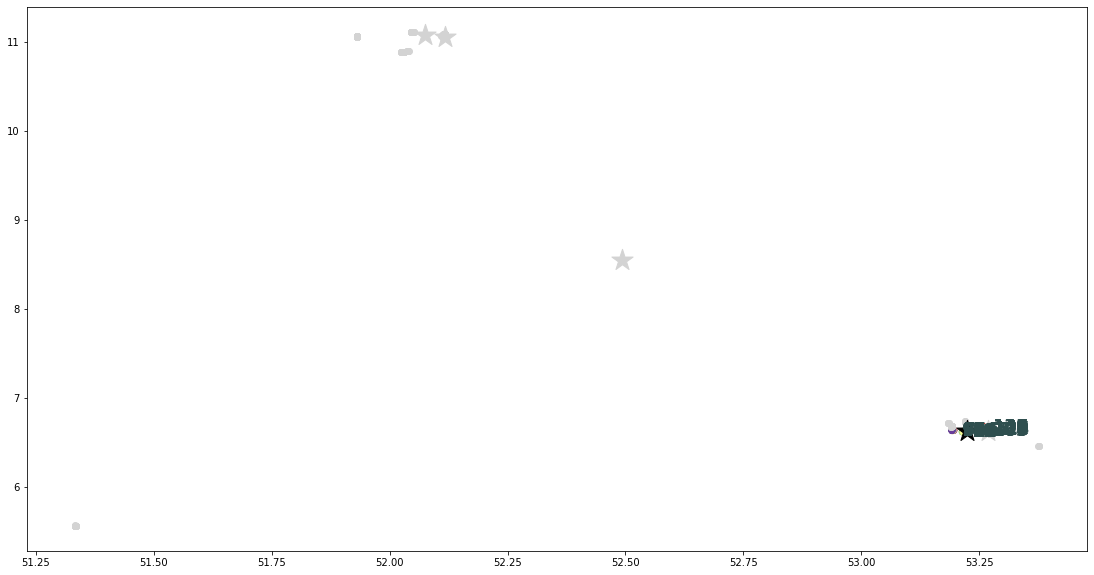

     index   latitude  longitude  cluster  subcluster  ordre_cluster  \
0        1  53.216527   6.629598        0          19              0   
1        2  53.218135   6.627840        0           9              1   
2        3  53.218005   6.627747        0           9              1   
3        4  53.217291   6.628167        0          47              2   
4        5  53.217395   6.627870        0          47              2   
..     ...        ...        ...      ...         ...            ...   
134    135  53.260159   6.675184        0          45             67   
135    136  53.260255   6.674633        0          64             68   
136    137  53.260914   6.675110        0          64             68   
137    138  53.259936   6.676243        0          31             69   
138    139  53.260757   6.676602        0          31             69   

     dist_botte  
0      0.011493  
1      0.011771  
2      0.011922  
3      0.012021  
4      0.012188  
..          ...  
134    0.

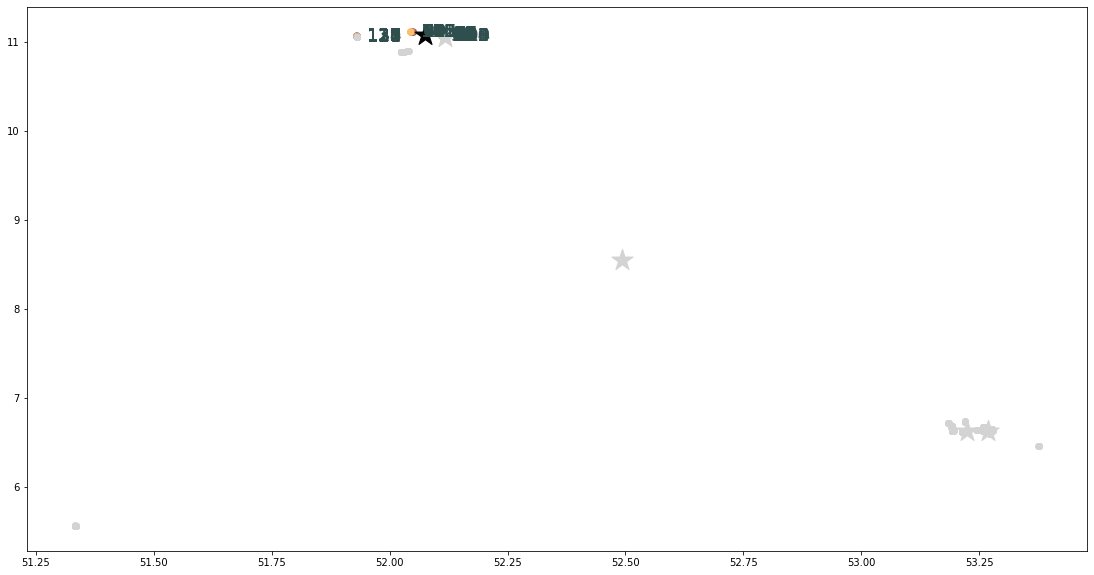

     index   latitude  longitude  cluster  subcluster  ordre_cluster  \
0        1  52.113497  11.082831        1          49              0   
1        2  52.051658  11.105218        1          49              0   
2        3  52.111229  11.067419        1          33              1   
3        4  52.111260  11.067398        1          33              1   
4        5  52.108585  11.061234        1          59              2   
..     ...        ...        ...      ...         ...            ...   
134    135  51.930120  11.060216        1          44             67   
135    136  51.930211  11.058038        1          42             68   
136    137  51.930054  11.058575        1          42             68   
137    138  51.930416  11.057761        1          47             69   
138    139  51.929990  11.056997        1          47             69   

     dist_botte  
0      0.039627  
1      0.040250  
2      0.036380  
3      0.036413  
4      0.035245  
..          ...  
134    0.

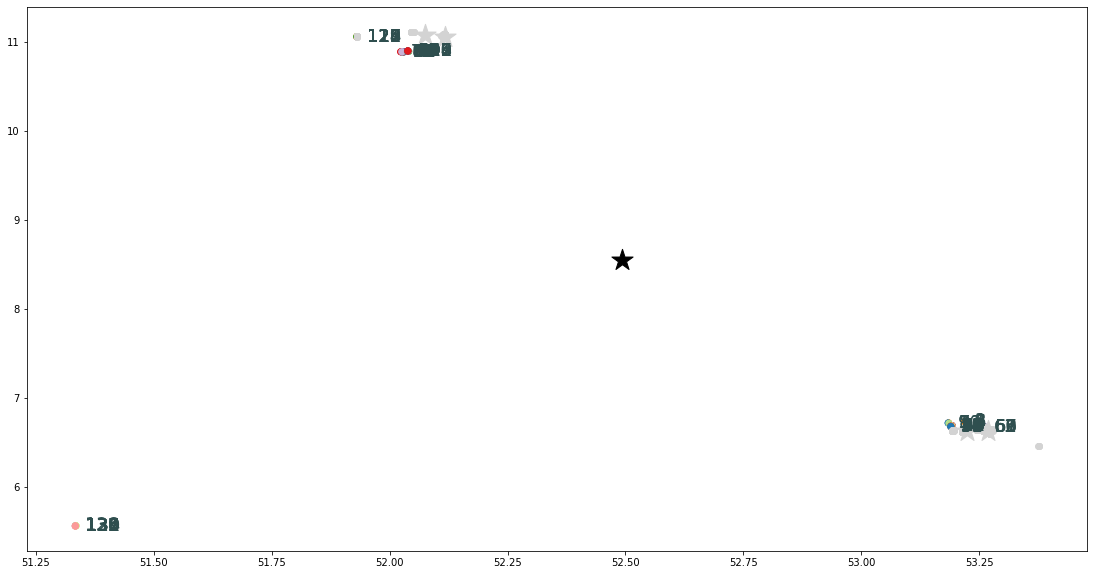

     index   latitude  longitude  cluster  subcluster  ordre_cluster  \
0        1  53.219124   6.738744        2          58              0   
1        2  53.220300   6.738663        2          58              0   
2        3  53.219261   6.738124        2           5              1   
3        4  53.219052   6.737573        2           5              1   
4        5  53.219282   6.737698        2          42              2   
..     ...        ...        ...      ...         ...            ...   
134    135  51.333766   5.567377        2          61             67   
135    136  51.333663   5.567036        2          28             68   
136    137  51.333484   5.566839        2          28             68   
137    138  51.332949   5.567277        2          24             69   
138    139  51.333125   5.565565        2          24             69   

     dist_botte  
0      1.947138  
1      1.947652  
2      1.947764  
3      1.948197  
4      1.948168  
..          ...  
134    3.

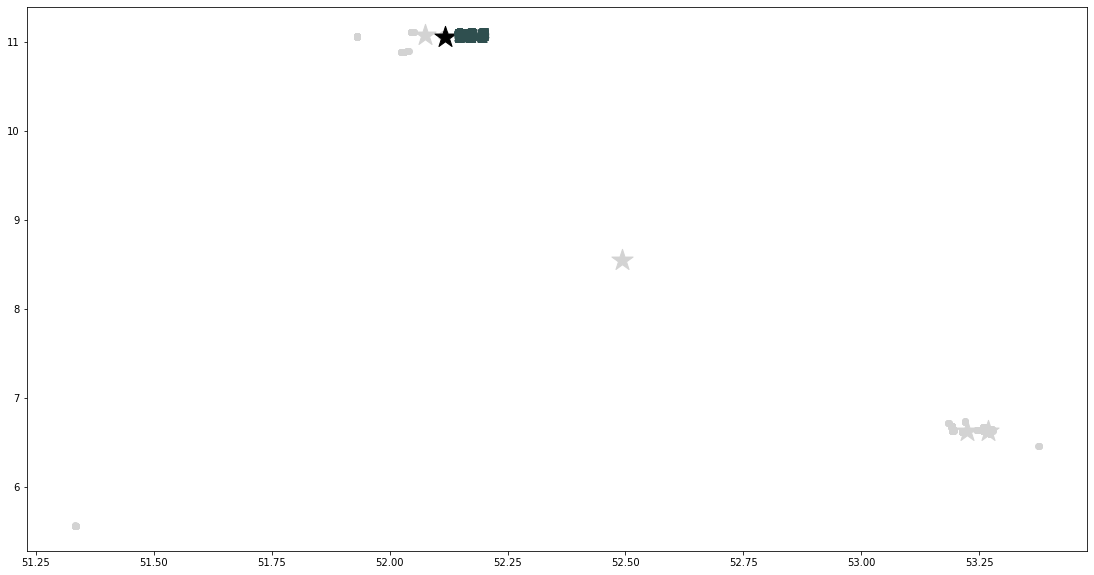

     index   latitude  longitude  cluster  subcluster  ordre_cluster  \
0        1  52.115515  11.048187        3          38              0   
1        2  52.115545  11.047930        3          38              0   
2        3  52.117412  11.048026        3           5              1   
3        4  52.117444  11.048160        3           5              1   
4        5  52.116068  11.048297        3          18              2   
..     ...        ...        ...      ...         ...            ...   
134    135  52.118878  11.058946        3           1             67   
135    136  52.118353  11.059456        3          19             68   
136    137  52.118581  11.059532        3          19             68   
137    138  52.120111  11.059115        3          20             69   
138    139  52.120077  11.059231        3          20             69   

     dist_botte  
0      0.001132  
1      0.001146  
2      0.000799  
3      0.000804  
4      0.000579  
..          ...  
134    0.

In [ ]:
for key in dfs.keys():
    print(key)
    df = dfs[key]
    print(df.shape[0])
    taille_remorque = max(df.shape[0]//5, 5)
    print(taille_remorque)
    clustering(dfs[key], key, size_trailer=taille_remorque)

# Test humidité

In [ ]:
clustering(dfs['ExportBales.csv'], 'ExportBales.csv', size_trailer=30, humidite_lim=(0.15, 0.20))

In [ ]:
for key in dfs.keys():
    print(dfs[key]["bale_info_moisture"].unique())